# I. Import the required libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# II. Loading the data

In [2]:
df = pd.read_csv('loan.csv', low_memory=False)

## Set display options for pandas (Show all columns, flexible column width)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

# III. Cleaning data

## 3.1. Dropping columns

### 3.1.1. List out the columns that has missing values

In [4]:
df.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

### Remove all the columns in which percentage of missing values is greater than 80%

In [5]:
total_rows = df.shape[0];
to_be_removed_columns = [];
for col_name, sum_of_null_value in df.isnull().sum().iteritems():
    if (sum_of_null_value / total_rows >= 0.8):
        to_be_removed_columns.append(col_name)

df.drop(columns=to_be_removed_columns, inplace=True)

### 3.1.2. Drop customer behavior columns
The Customer behavior variables are not available at the time of loan application, and thus they cannot be used as predictor for credit approval

In [6]:
customer_behavior_columns = [
    'delinq_2yrs',
    'earliest_cr_line',
    'inq_last_6mths',
    'open_acc',
    'pub_rec',
    'revol_bal',
    'revol_util',
    'total_acc',
    'out_prncp',
    'out_prncp_inv',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'total_rec_prncp',
    'total_rec_late_fee',
    'recoveries',
    'collection_recovery_fee',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'last_credit_pull_d'
]
df.drop(columns=customer_behavior_columns, inplace=True)

### 3.1.3. Drop another columns

1. Checking through the `application_type`, the only value is `INDIVIDUAL`
So all the records are invidual application, not joint, we will remove all the columns that indicates co-borrowers. Those are:
- `annual_inc_joint`
- `dti_joint`
- `verified_status_joint`

And we should remove the `application_type` as well, as the column contains only 1 value

In [7]:
df.drop(
    columns=['annual_inc_joint', 'dti_joint', 'verified_status_joint', 'application_type'],
    errors='ignore', 
    inplace=True
)

2. List out the columns with unique value count

In [8]:
df.nunique()

id                            39717
member_id                     39717
loan_amnt                       885
funded_amnt                    1041
funded_amnt_inv                8205
term                              2
int_rate                        371
installment                   15383
grade                             7
sub_grade                        35
emp_title                     28820
emp_length                       11
home_ownership                    5
annual_inc                     5318
verification_status               3
issue_d                          55
loan_status                       3
pymnt_plan                        1
url                           39717
desc                          26527
purpose                          14
title                         19615
zip_code                        823
addr_state                       50
dti                            2868
mths_since_last_delinq           95
initial_list_status               1
collections_12_mths_ex_med  

We should remove the columns with count of unique value is 1, as it will have no effect on the analysis

In [9]:
to_be_removed_columns = [];
for col_name, unique_value in df.nunique().iteritems():
    if (unique_value == 1):
        to_be_removed_columns.append(col_name)
        
df.drop(columns=to_be_removed_columns, inplace=True)

The `url` and `desc` is also unneeded for analysis. Let's remove them

In [10]:
df.drop(columns=['url', 'desc'], inplace=True)

Since the `purpose` is clearer and it can includes the meaning of `title`, let's remove `title` as well

In [11]:
df.drop(columns=['title'], inplace=True)

## 3.2. Cleaning rows

### 3.2.1. Removing `Current` loan status

We will remove the rows with `loan_status` is `Current` because we only need to analyze loans that are ended (`Fully Paid` or `Charge Off`)

In [12]:
df = df[df.loan_status != 'Current']

### 3.2.2. Removing outliers

Check for `annual_inc` column:

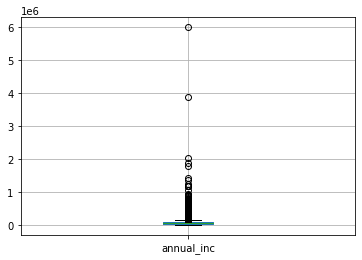

In [13]:
df.boxplot(column=['annual_inc'])
plt.show()

We can see in the above boxplot for `annual_inc`, the max value is too high compare to the upper threshold, we need to remove those outliers

In [14]:
df = df[df.annual_inc < df.annual_inc.quantile(0.99)]

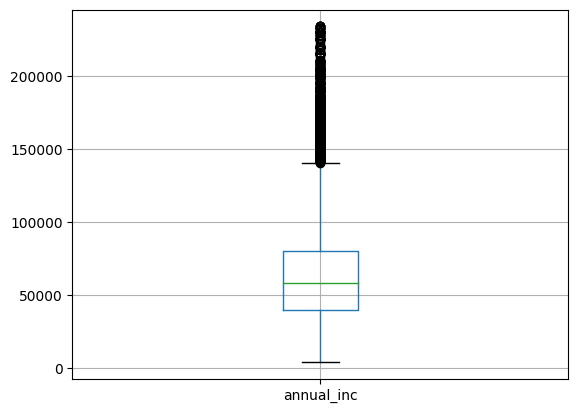

In [15]:
df.boxplot(column=['annual_inc'])
plt.show()

The boxplot is now easier to look at

### 3.2.3. Convert data to correct type

Check data type of all columns

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38191 entries, 0 to 39716
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      38191 non-null  int64  
 1   member_id               38191 non-null  int64  
 2   loan_amnt               38191 non-null  int64  
 3   funded_amnt             38191 non-null  int64  
 4   funded_amnt_inv         38191 non-null  float64
 5   term                    38191 non-null  object 
 6   int_rate                38191 non-null  object 
 7   installment             38191 non-null  float64
 8   grade                   38191 non-null  object 
 9   sub_grade               38191 non-null  object 
 10  emp_title               35846 non-null  object 
 11  emp_length              37163 non-null  object 
 12  home_ownership          38191 non-null  object 
 13  annual_inc              38191 non-null  float64
 14  verification_status     38191 non-null

#### - `int_rate` (Interest rate) should be a number

In [17]:
df.int_rate.value_counts()

10.99%    904
11.49%    786
7.51%     782
13.49%    744
7.88%     717
         ... 
16.96%      1
18.36%      1
16.15%      1
16.01%      1
16.20%      1
Name: int_rate, Length: 370, dtype: int64

Let's remove the % mark and convert it to number

In [18]:
df.int_rate = pd.to_numeric(df.int_rate.apply(lambda x: x.replace('%', '')))

df.int_rate.describe()

#### - `issue_d` (The issuing date must be a date)

In [19]:
df.issue_d.value_counts() #Check format of datetime

Nov-11    2045
Dec-11    2025
Oct-11    1913
Sep-11    1891
Aug-11    1781
Jul-11    1730
Jun-11    1709
May-11    1593
Apr-11    1548
Mar-11    1427
Jan-11    1369
Feb-11    1287
Dec-10    1255
Oct-10    1117
Nov-10    1114
Jul-10    1112
Sep-10    1075
Aug-10    1073
Jun-10    1020
May-10     908
Apr-10     819
Mar-10     722
Feb-10     617
Nov-09     592
Dec-09     588
Jan-10     580
Oct-09     539
Sep-09     447
Aug-09     405
Jul-09     367
Jun-09     350
May-09     316
Apr-09     286
Mar-09     276
Feb-09     259
Jan-09     237
Mar-08     234
Dec-08     222
Nov-08     183
Feb-08     174
Jan-08     168
Apr-08     155
Oct-08      94
Dec-07      85
Jul-08      83
Aug-08      71
May-08      70
Jun-08      66
Oct-07      46
Nov-07      35
Aug-07      33
Sep-08      32
Jul-07      29
Sep-07      18
Jun-07       1
Name: issue_d, dtype: int64

In [20]:
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%y')

#### - trim `term` columns

In [21]:
df.term = df.term.apply(lambda x: x.strip())

### 3.2.4. Imputing data

**Check for missing values**

In [22]:
df.isnull().sum()

id                            0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                  2345
emp_length                 1028
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
mths_since_last_delinq    24676
pub_rec_bankruptcies        688
dtype: int64

In [23]:
df.shape

(38191, 23)

***Since the total rows with missing value for `emp_length` is low (1028 compare to 39319). Let's remove those rows***

In [24]:
df = df[df.emp_length.notnull()]

In [25]:
df['emp_title'] = df['emp_title'].fillna('None') # Also fill None to the missing `emp_title`

In [26]:
df.isnull().sum() # Check missing value again

id                            0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
mths_since_last_delinq    23978
pub_rec_bankruptcies        688
dtype: int64

***Now the data is ready for analysis***

In [27]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,mths_since_last_delinq,pub_rec_bankruptcies
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,None,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,credit_card,860xx,AZ,27.65,NaN,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,car,309xx,GA,1.00,NaN,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,None,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,small_business,606xx,IL,8.72,NaN,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,other,917xx,CA,20.00,35.0,0.0
5,1075269,1311441,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,2011-12-01,Fully Paid,wedding,852xx,AZ,11.20,NaN,0.0


In [28]:
df.shape

(37163, 23)

# IV. Data analysis

## 4.1. Univariate analysis

Let's do some univariate analysis

### 4.1.1 Loan Status

Let's take a look on the `loan_status`

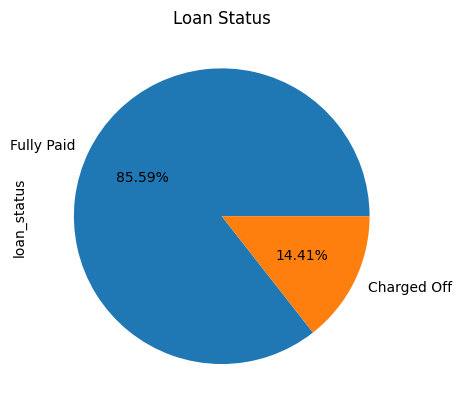

In [29]:
df.loan_status.value_counts().plot(kind='pie', title='Loan Status', autopct=lambda pct: '%.2f' % pct + '%')
plt.show()

#### Insights
- Among 37163 loan applications, 14.41% was charged off

### 4.1.2. Loans amount

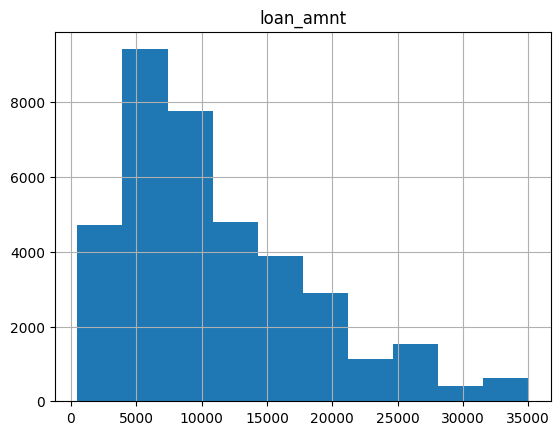

In [30]:
df.hist(column=['loan_amnt'])
plt.show()

#### Insights
People seems to apply most for the loan range from 4500 - 7000

### 4.1.3. Loan purpose

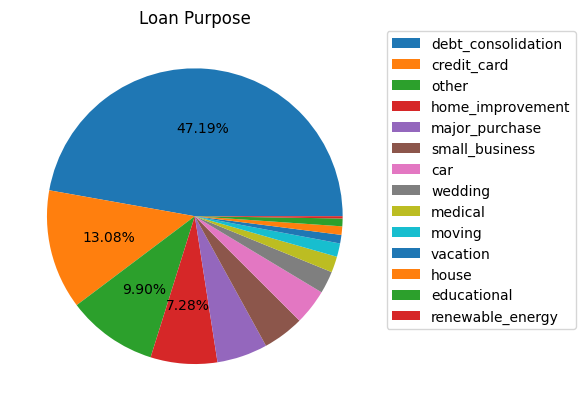

In [31]:
chart = df.purpose.value_counts().plot(
    kind='pie',
    title='Loan Purpose',
    autopct=lambda pct: '%.2f' % pct + '%' if pct > 6 else '',
    legend=True,
    ylabel='',
    labeldistance=None
)
chart.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

#### Insights
- Most of the loans were for the purpose of paying dept, following by credit card and other

### 4.1.4. Issuing date
Let's create two new columns:
- `issue_month`: The month when the loan was issued
- `issue_year`: The year when the loan was issue

In [32]:
df['issue_month'] = pd.DatetimeIndex(df['issue_d']).month
df['issue_year'] = pd.DatetimeIndex(df['issue_d']).year

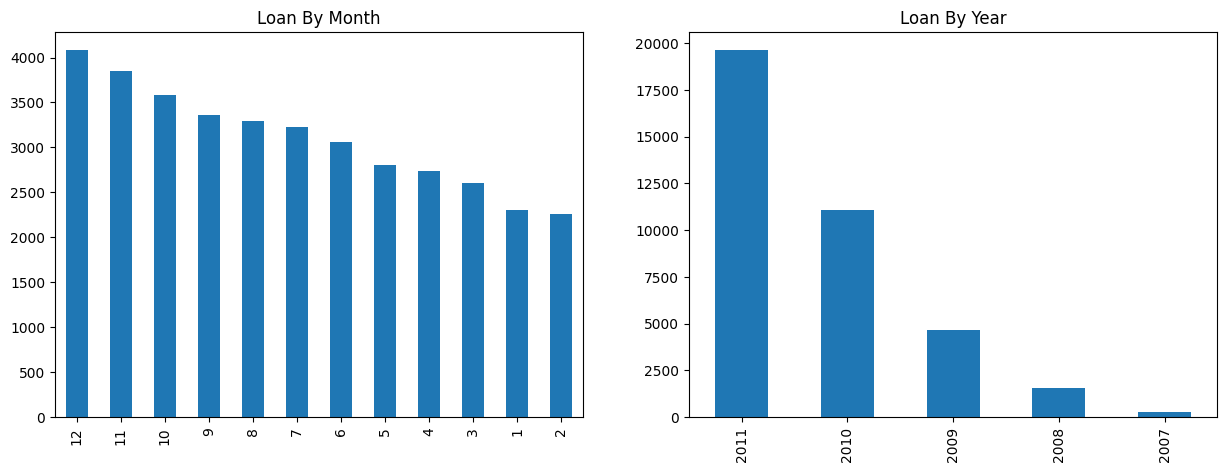

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
df.issue_month.value_counts().plot(kind='bar', title='Loan By Month', ax=axes[0])
df.issue_year.value_counts().plot(kind='bar', title='Loan By Year', ax=axes[1])
plt.show()

#### Insights
- Loans was issued mostly during the end of the year (October, November, December)
- Number of loans increased year by year

### 4.1.5. Employment length

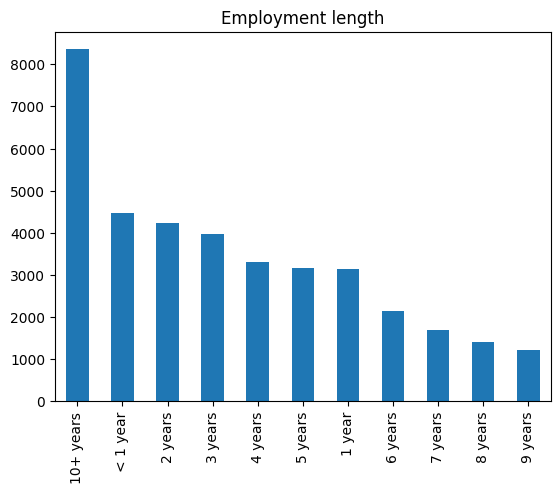

In [34]:
chart = df.emp_length.value_counts().plot(
    kind='bar',
    title='Employment length',
)
plt.show()

#### Insights
- Most of the loans were made by people with more than 10 years of employment

### 4.1.6. Annual Income

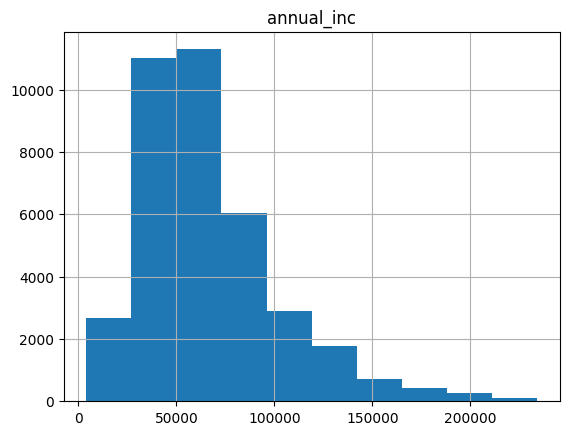

In [35]:
df.hist(column=['annual_inc'])
plt.show()

#### Insights
- Most of the loans were made by people with annual income from 25000 to 75000

### 4.1.7. Summary
Univariate analysis can only show us the distribution of data for one column, it cannot be used to see the difference between Fully Paid and Charged Off loans. In order to do so, we have to move on to bivariate analysis

## 4.2. Bivariate Analysis

In **Bivariate Analysis**, we will see the impact of factors on the loans (which factors cause the largest Charge Off Percentage)

In [36]:
## Create a function to analyze the relation between 2 variables (mainly one factor vs loan_status)
def bivariate_analysis(
    dataframe,
    column,
    title,
    show_in_row=True,
    secondary_column = 'loan_status',
    secondary_title = 'Charge off Percentage'
):
    # Create 2 dataframe (1 for count and 1 for percentage)
    count_df = dataframe.groupby([column, secondary_column]).size();
    percentage_df = count_df * 100 / count_df.groupby(level=0).sum();
    # Draw 2 dataframe into chart
    if show_in_row:
        fig, axes = plt.subplots(ncols=2, figsize=(15,5))
    else:
        fig, axes = plt.subplots(nrows=2, figsize=(15,12))
    count_chart = count_df.unstack().plot(kind='bar', stacked=True, title=title + " vs " + secondary_title, ax=axes[0], xlabel='')
    count_chart.legend(bbox_to_anchor=(1, 1), loc='upper right')
    percentage_chart = percentage_df.unstack().plot(kind='bar', title=secondary_title + ' (%)', stacked=True, ax=axes[1], xlabel='')
    percentage_chart.legend(bbox_to_anchor=(1, 1), loc='upper right')
    
    filename = column+'_vs_'+secondary_column+'.png' if secondary_column != 'loan_status' else column+'_vs_charged_off_percentage.png'
    fig.savefig(column+'_vs_charged_off_percentage.png');
    
    plt.show()

### 4.2.1. Terms and Charge Off Percentage

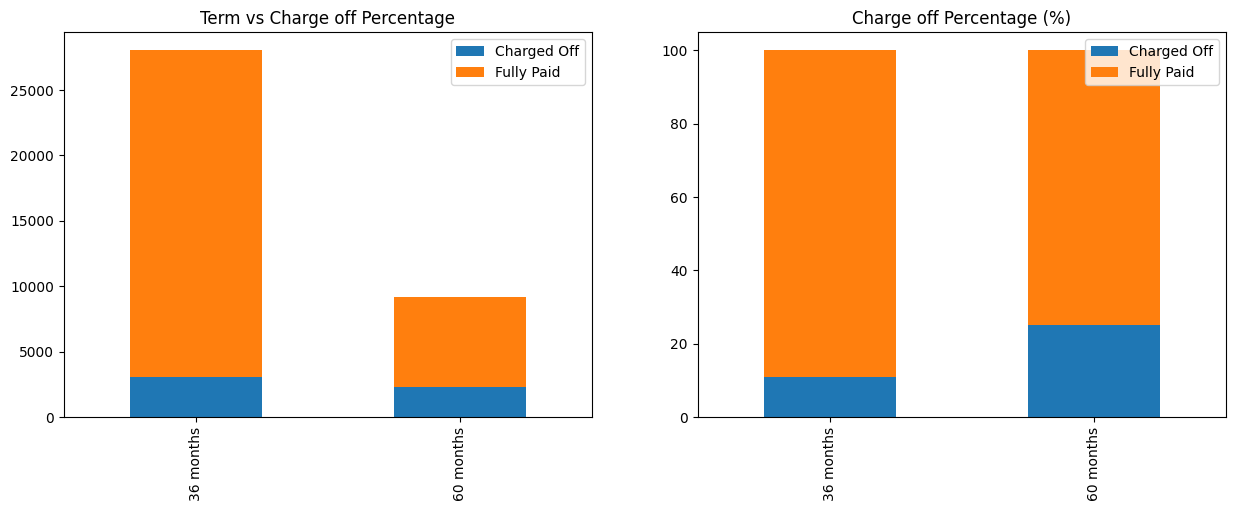

In [37]:
bivariate_analysis(dataframe=df, column='term', title='Term')

#### Insights:
- Most of the loans were paid in 36 months term.
- However, 60-months loans saw a higher percentage in charged off compare to 36-months loans (25% compare to 10%)

### 4.2.2. Purpose vs Charged Off Percentage

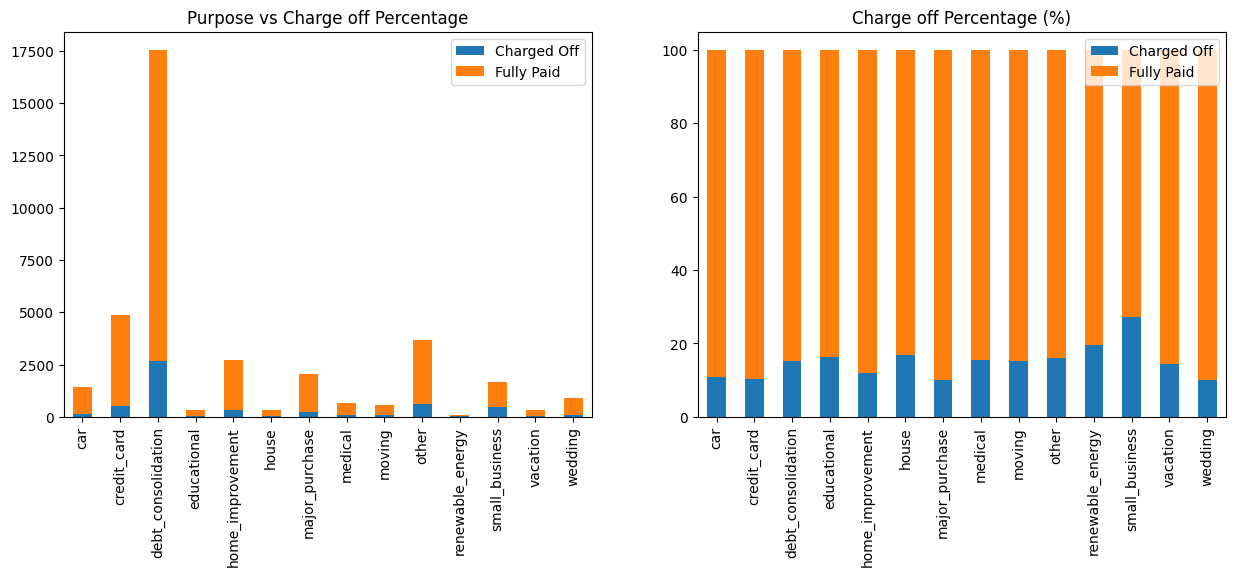

In [38]:
bivariate_analysis(dataframe=df, column='purpose', title='Purpose')

#### Insights:
- Loans with the purpose of `small_business` saw the most charged off percentage (25%), following by `renewable_energy`

***Let's have a little deep dive in to the `small_business` charged off loans***

In [39]:
small_business_charged_off_df = df[df.purpose == 'small_business']

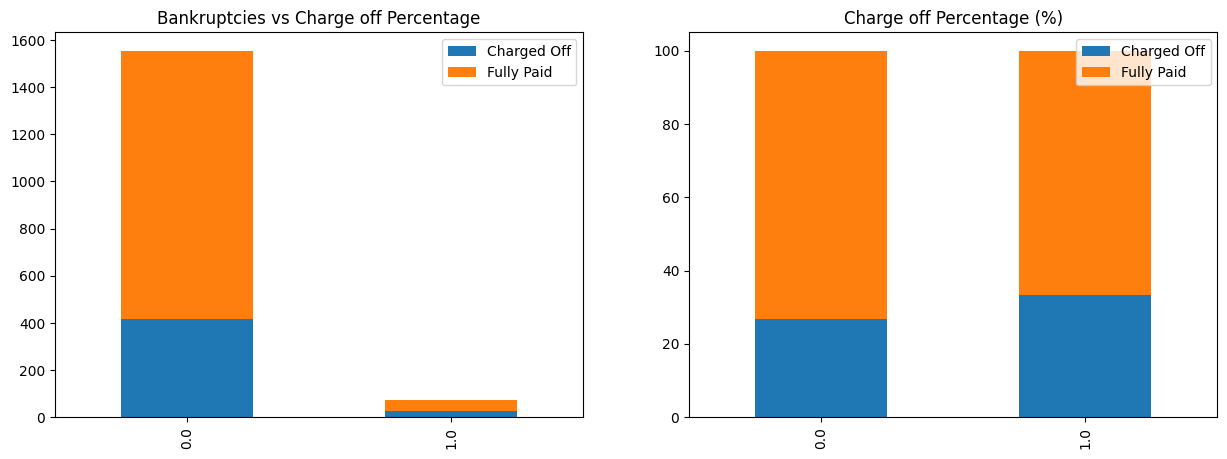

In [40]:
bivariate_analysis(dataframe=small_business_charged_off_df, column='pub_rec_bankruptcies', title='Bankruptcies')

#### Insights:
- Only few loans for small business had previous bankruptcies. However, the percentage of charged off loans is higher in those loans

### 4.2.3. Home ownership vs Charged Off Percentage

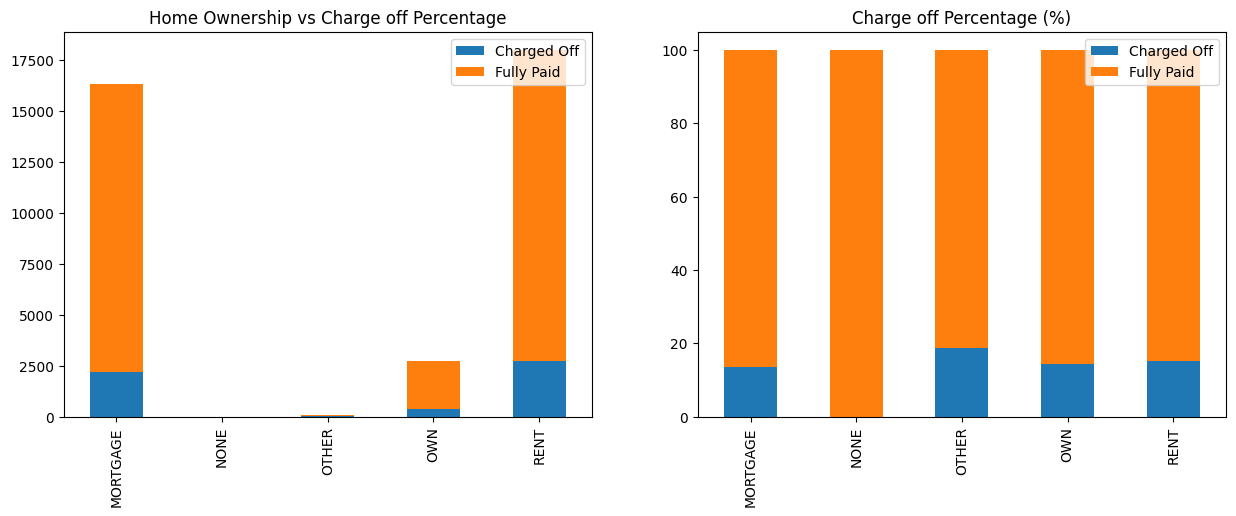

In [41]:
bivariate_analysis(dataframe=df, column='home_ownership', title='Home Ownership')

#### Insights:
- There is no big difference in charged off percentage between Home Ownership status, Home Ownership seems not to be a driving factor for charged off loans

### 4.2.4. Grade, Subgrade vs Charged Off Percentage

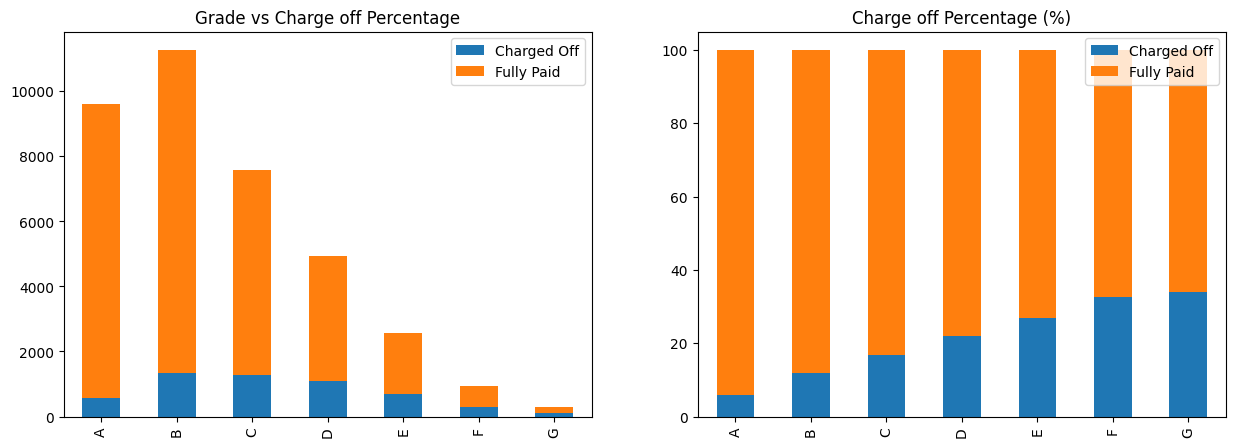

In [42]:
bivariate_analysis(dataframe=df, column='grade', title='Grade')

#### Insights:
- The charged off percentage seems to increase from grade A -> G, highest in F and G (around 30%)

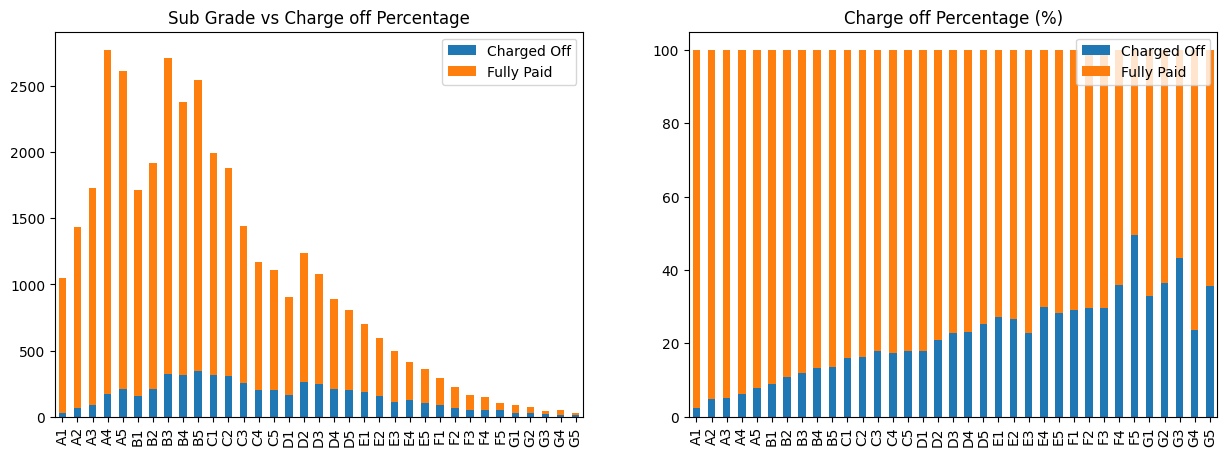

In [43]:
bivariate_analysis(dataframe=df, column='sub_grade', title='Sub Grade')

#### Insights:
- The charged off percentage increase in subgroup (Eg: A1 -> A5), except for group **G**, where **G4** is the lowest in charged of percentage.
- **F5** records the highest charged off percentage amongst all subgrade.

### 4.2.5. Verification Status vs Charged Off Percentage

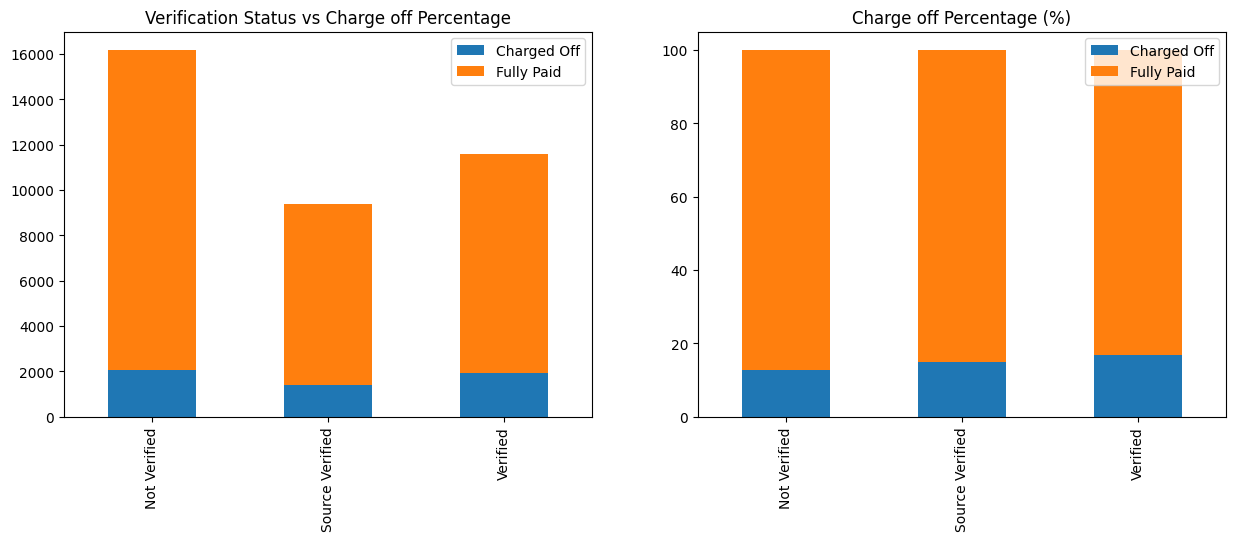

In [44]:
bivariate_analysis(dataframe=df, column='verification_status', title='Verification Status')

#### Insights:
- Although there is no big difference in charged off percenrage between **Verification Status**, but interestingly, the loans with Verified Income records the highest Charge off Percentage

### 4.2.6. Address vs Charged Off Percentage

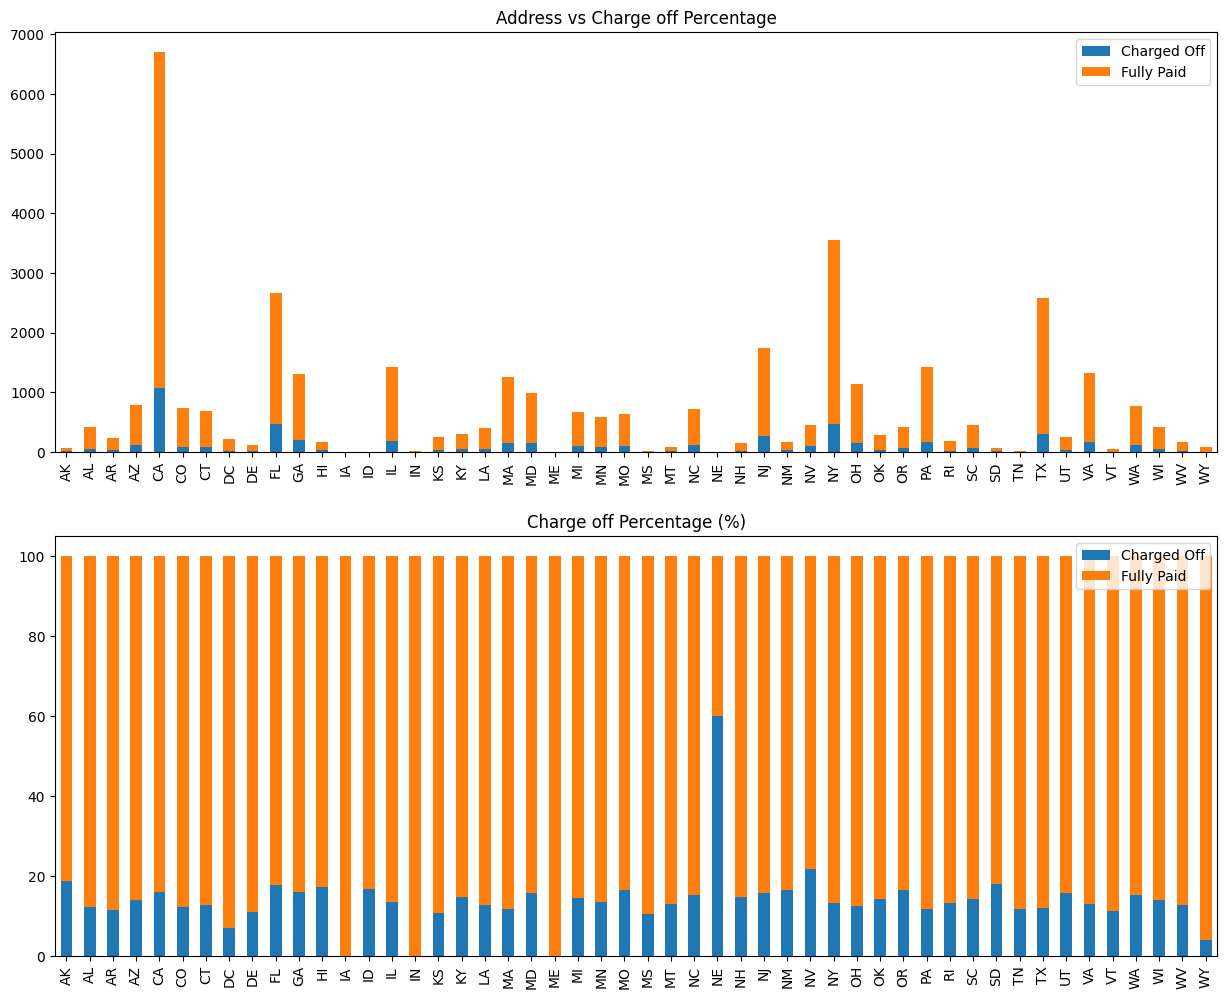

In [45]:
bivariate_analysis(dataframe=df, column='addr_state', title='Address', show_in_row=False)

#### Insights:
- Most of the loans were issued to people from CA (California)
- Nebraska (NE) records an outstanding charged off rate compare to another state (over 60%)

### 4.2.7. Loan amount vs Charged Off Percentage

Let's bin the data first

In [46]:
bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000]
df['loan_amount_bin'] = pd.cut(df['loan_amnt'], bins)

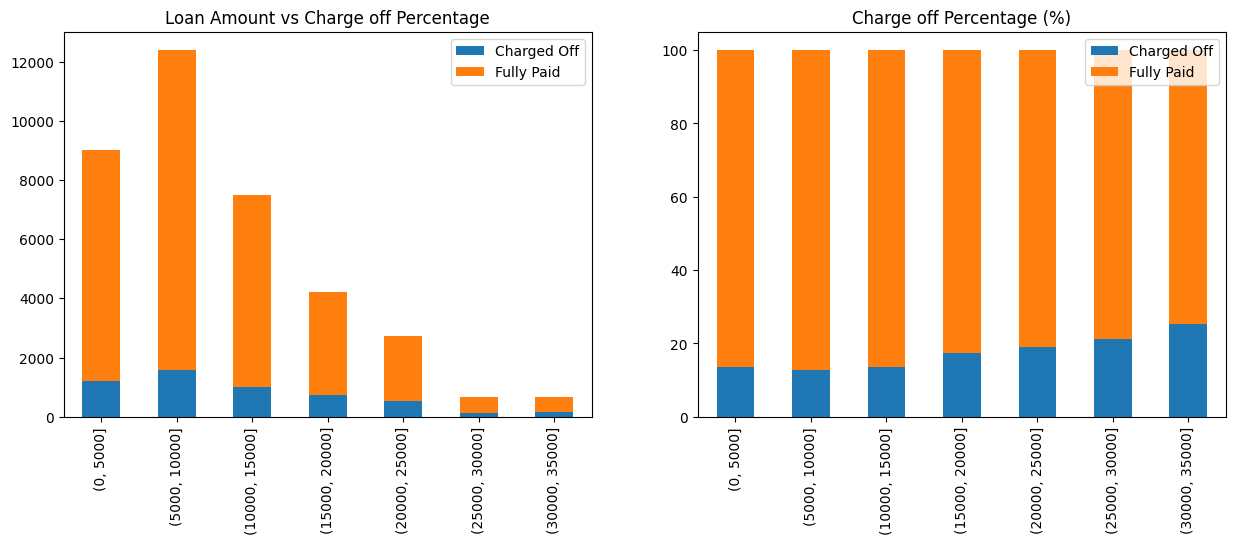

In [47]:
bivariate_analysis(dataframe=df, column='loan_amount_bin', title='Loan Amount')

#### Insights:
- Most of the loans were between 5000 and 10000
- Charge of percentage seems to increase when loan amount increase

### 4.2.8. Interest Rate vs Charged Off Percentage

In [48]:
## Binning the data
bins = [0, 5, 10, 15, 20, 25]
df['int_rate_bin'] = pd.cut(df['int_rate'], bins)

Since interest rate is different between 36 and 60 months loans, we will separate them

### 36-month loans

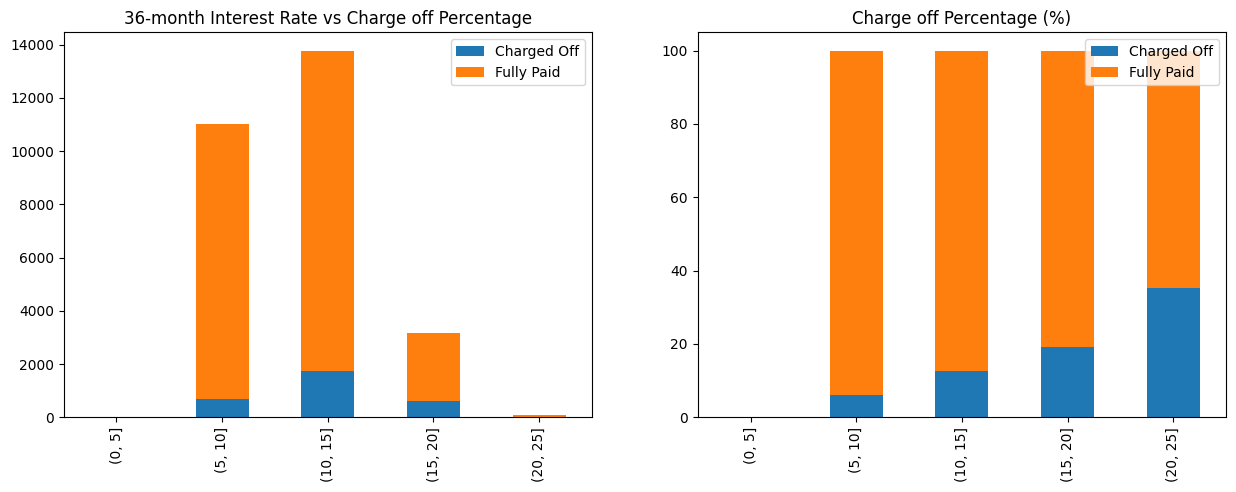

In [49]:
bivariate_analysis(dataframe=df[df.term == '36 months'], column='int_rate_bin', title='36-month Interest Rate')

### 60-month loans

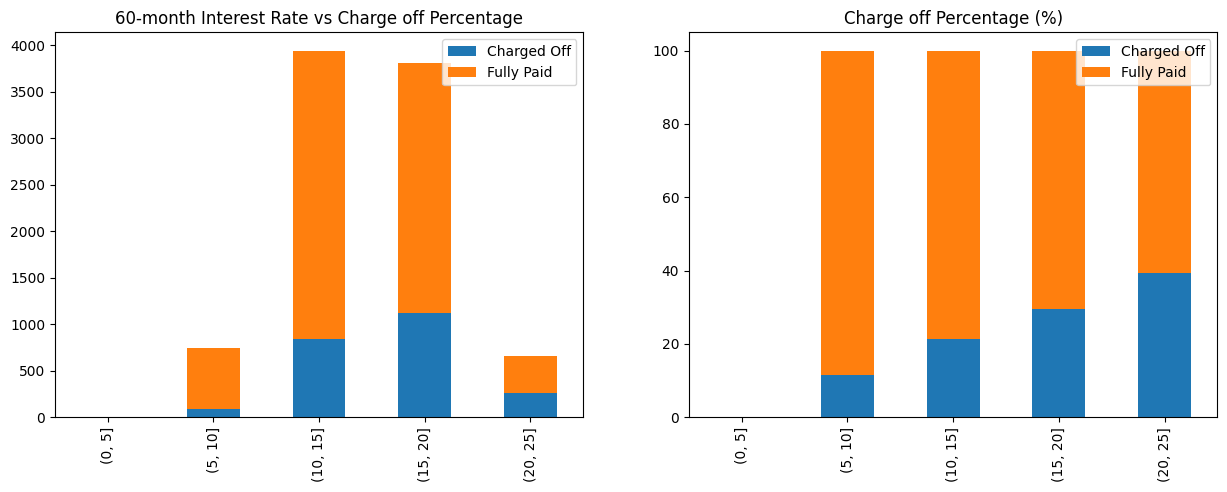

In [50]:
bivariate_analysis(dataframe=df[df.term == '60 months'], column='int_rate_bin', title='60-month Interest Rate')

#### Insights:
- The higher the interest rate, the higher charge off percentage

### 4.2.9. Annual Income vs Charged Off Percentage

In [51]:
## Binning the data
bins = [0, 25000, 50000, 75000, 100000, 150000, 200000, 250000]
df['annual_inc_bin'] = pd.cut(df['annual_inc'], bins)

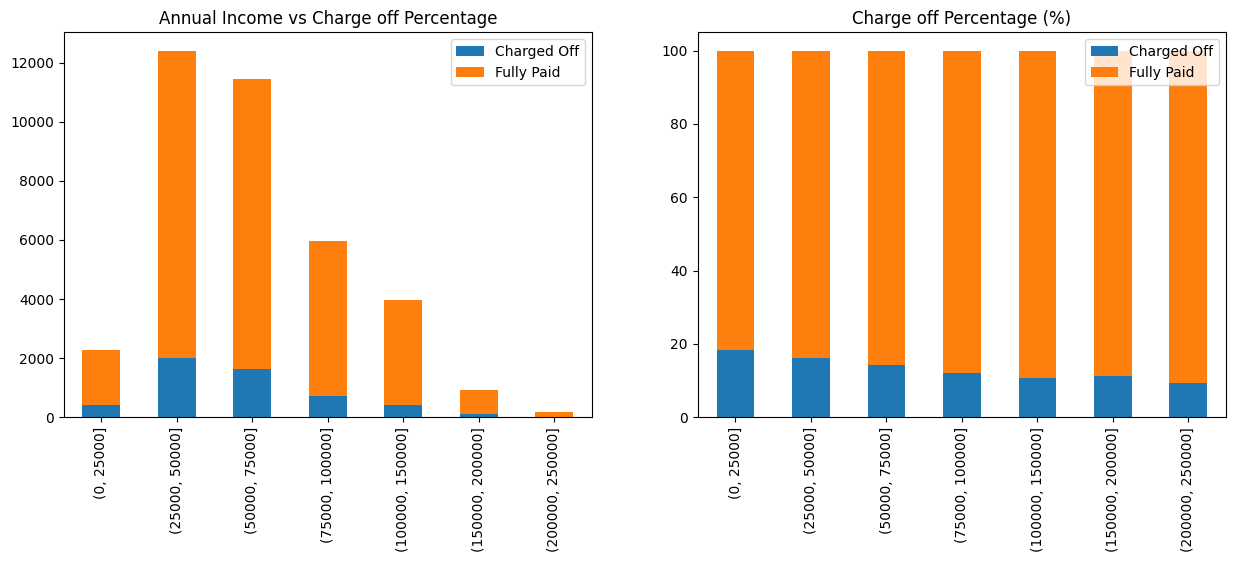

In [52]:
bivariate_analysis(dataframe=df, column='annual_inc_bin', title='Annual Income')

#### Insights:
- Charged Off Percentage is the highest in the 0-25k and 25k-50k income group.

***Let's take a little deep into the annual income vs verification status***

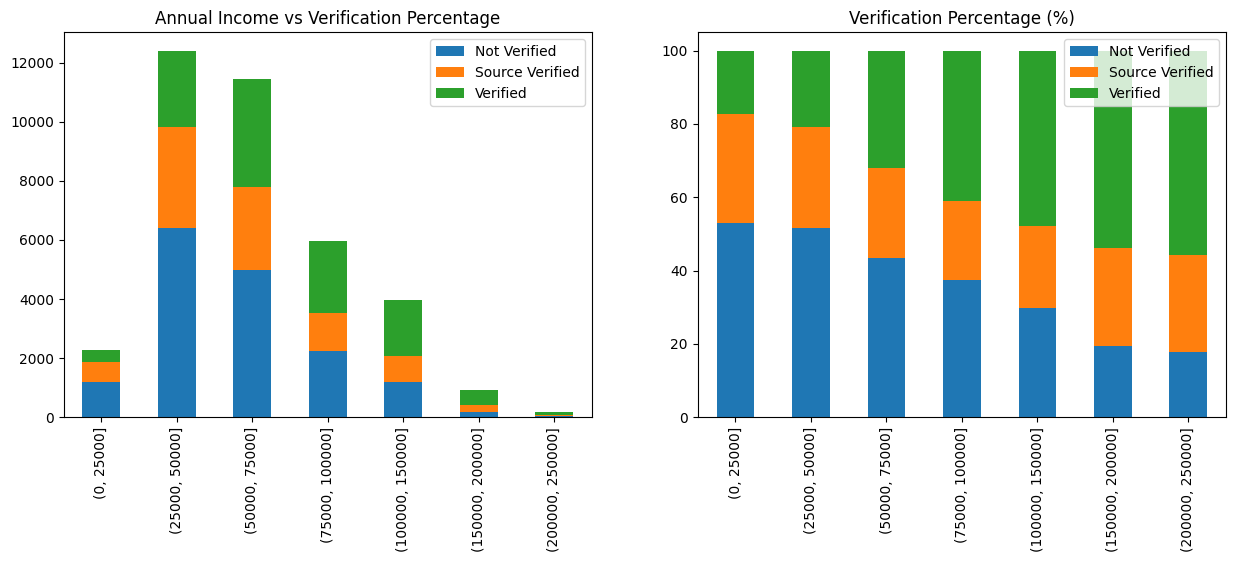

In [53]:
bivariate_analysis(
    dataframe=df,
    column='annual_inc_bin',
    title='Annual Income',
    secondary_column='verification_status',
    secondary_title='Verification Percentage'
)

#### Insights:
- Most of the income from 0-25k, 25k-50k, 50k-75k group is not verified

 ### 4.2.10. Employment years vs Charged Off Percentage

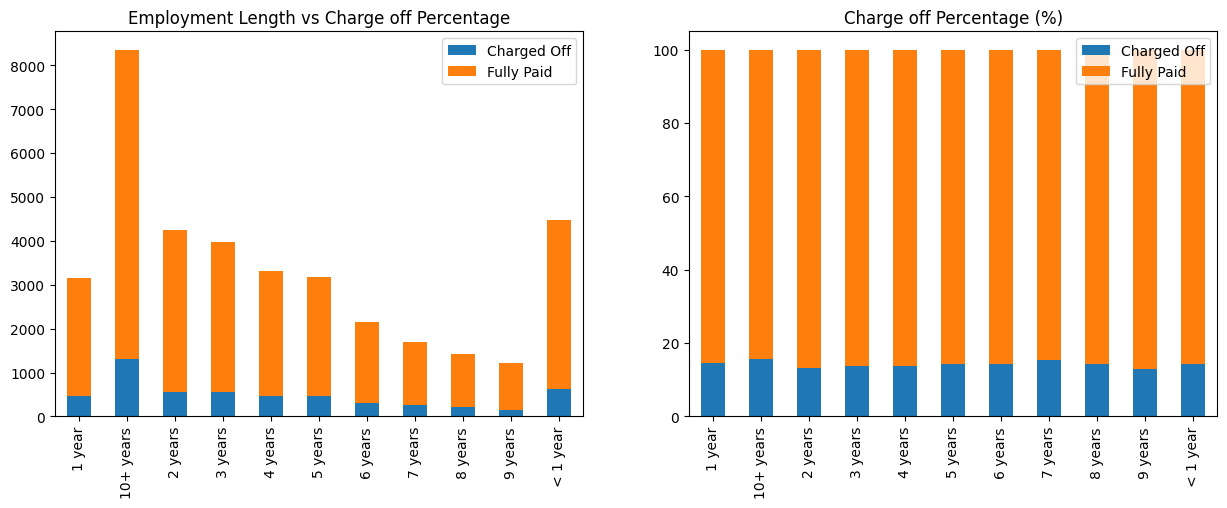

In [54]:
bivariate_analysis(dataframe=df, column='emp_length', title='Employment Length')

#### Insights:
- There is no big difference in Charged Off Percentage between employment years of loans' applicants

 ### 4.2.11. DTI vs Charged Off Percentage

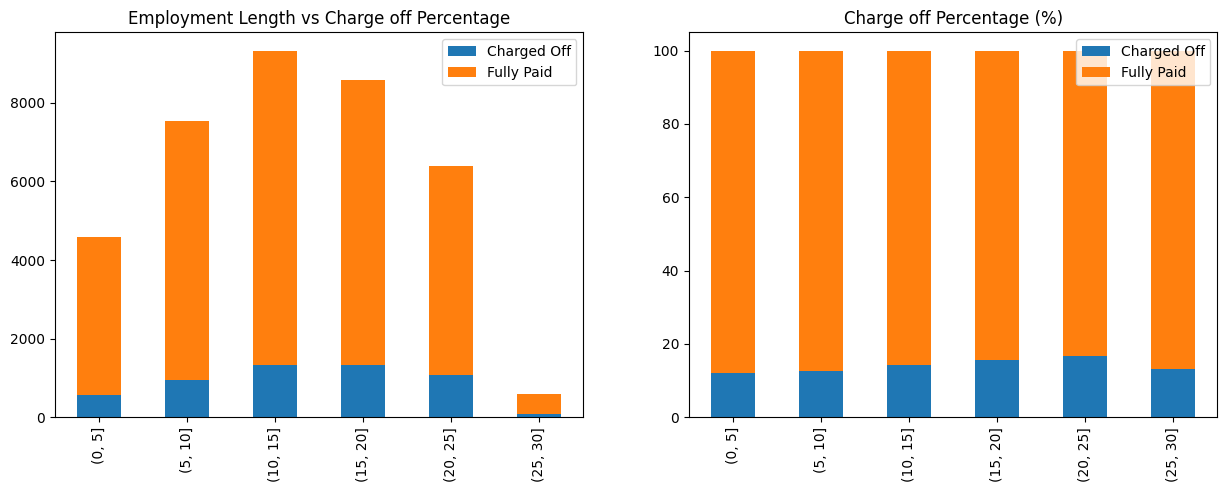

In [55]:
## Binning the data
bins = [0, 5, 10, 15, 20, 25, 30]
df['dti_bin'] = pd.cut(df['dti'], bins)
bivariate_analysis(dataframe=df, column='dti_bin', title='Employment Length')

#### Insights:
- There is no big difference in Charged Off Percentage between DTI groups

### 4.2.12. Summary

**After analyzing the factors, we can summarize:**
- **High effect factors**
    - Terms
    - Interest Rate
    - Annual Income and Verification Status
    - Grade and Subgrade
    - Loan Purpose
    - Loan Amount
    - Address
- **Low or None effect factors**
    - DTI
    - Employment Length
    - Home Ownership

# V. Business Recommendations

- Lending Club should be careful of the loans which term is 60-month, as the Charged Off Rate is much higher than 36-month loans (30% compare to 15%)
- Lending Club should be cautious when the lending purpose is **Small Business**, especially when the applicants had already had a public record bankruptcy
- Leading Club should also take the applicant's LC assigned loan grade and subgrade into consideration. Grade A and B are more likely to repay the loan, while F and G are more likely to charge off. F5 has the highest charged off rate, so Lending Club should be careful of F5 applicants.
- Among all the state, Lending Club should be wary of Nebraska (NE) loans, the charge off rate in this state is very high (over 60%)
- The higher the loan amount, the higher the charged off rate, Lending Club should be careful of the loans that has the amount over 15000
- Annual income below 75000 is very low in Verification Status (Over 40% Unverified), and thus the Charged Off Percentage is high among those applicants whose income is below 75k. Lending Club need to be more careful with those applicants.